In [ ]:
!pip install catboost gdown imblearn

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random, string 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import gdown


url = 'https://drive.google.com/uc?id='


gdown.download(url + "10GPFaBbBUOgADgH572W6WxeAITqHZeTD", output="Update_train.csv",quiet=False)

gdown.download(url+"10BL_rF885GDITOW6sHtj_sHYdBqQbibj",output="Updated_test.csv",quiet=False)
maindir = "." # Directory with your files
traincsv = maindir+"/Update_train.csv"
testcsv = maindir+"/Updated_test.csv"

Downloading...
From: https://drive.google.com/uc?id=10GPFaBbBUOgADgH572W6WxeAITqHZeTD
To: /content/Update_train.csv
100%|██████████| 82.5M/82.5M [00:01<00:00, 56.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=10BL_rF885GDITOW6sHtj_sHYdBqQbibj
To: /content/Updated_test.csv
100%|██████████| 10.4M/10.4M [00:00<00:00, 62.7MB/s]


## Quick look at the DATA

In [ ]:
train = pd.read_csv(traincsv)
train.head()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,absorbance39,...,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,id,std,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id
0,0.520883,0.528200,0.529795,0.537382,0.540265,0.546260,0.550882,0.558865,0.571352,0.585775,0.600688,0.612949,0.617855,0.621710,0.622049,0.623373,0.620610,0.619479,0.616463,0.612414,0.609885,0.605408,0.602115,0.597710,0.593485,0.592332,0.588680,0.587396,0.585577,0.585244,0.583597,0.584460,0.584548,0.586147,0.589067,0.591360,0.595636,0.599054,0.602856,0.607817,...,1.468505,1.454910,1.434286,1.443249,1.417403,1.418581,1.403326,1.395943,1.386288,1.381532,1.372256,1.367083,1.362999,1.353013,1.345374,1.341283,1.323804,1.331071,1.332295,1.328928,1.309800,1.328064,1.329464,1.314664,1.313583,1.313329,1.312243,1.310330,1.353629,1.336609,1.319344,1.278294,0,0.0026,39.27,44.17,low,ok,high,2250
1,0.529109,0.534852,0.541075,0.544269,0.546594,0.555183,0.561367,0.567637,0.582427,0.595801,0.608619,0.619217,0.625162,0.627111,0.629326,0.628116,0.627815,0.623644,0.620762,0.617781,0.613032,0.610404,0.605528,0.602216,0.598417,0.595489,0.593692,0.591697,0.590110,0.589316,0.589131,0.587455,0.589060,0.589305,0.591252,0.594853,0.598545,0.601338,0.605673,0.610725,...,1.477741,1.457003,1.445143,1.439036,1.434363,1.422782,1.408831,1.405730,1.394905,1.386579,1.373887,1.376208,1.360633,1.358802,1.353009,1.344997,1.332883,1.324965,1.339512,1.336343,1.322957,1.311612,1.316437,1.316180,1.316063,1.320698,1.321068,1.286939,1.301804,1.314457,1.282723,1.267465,1,0.0026,39.39,44.09,low,ok,high,2250
2,0.528434,0.532036,0.540413,0.541964,0.549347,0.555902,0.561458,0.567824,0.579568,0.593048,0.607972,0.617558,0.624398,0.626222,0.627771,0.626445,0.623953,0.622616,0.618701,0.615181,0.611624,0.608587,0.605730,0.601288,0.597154,0.595654,0.592535,0.591893,0.589885,0.588528,0.587108,0.586997,0.589043,0.588888,0.591670,0.594962,0.597498,0.600767,0.604963,0.612166,...,1.468838,1.456374,1.450920,1.438182,1.434188,1.427201,1.413866,1.403336,1.404049,1.383698,1.378195,1.374761,1.373550,1.362671,1.350157,1.344038,1.341004,1.335655,1.333660,1.325491,1.335868,1.334114,1.327512,1.339627,1.322394,1.328299,1.311948,1.310330,1.311108,1.283048,1.287730,1.266464,2,0.0026,39.50,44.00,low,ok,high,2250
3,0.530528,0.531880,0.539558,0.542433,0.549097,0.556224,0.561398,0.566963,0.577525,0.591982,0.607109,0.616252,0.622437,0.625715,0.626799,0.625676,0.625084,0.622652,0.618510,0.614896,0.611060,0.608285,0.603976,0.600319,0.596856,0.594169,0.591334,0.589620,0.589549,0.587194,0.586685,0.587205,0.587368,0.588510,0.592029,0.593472,0.597904,0.601190,0.604864,0.610652,...,1.474065,1.456521,1.456408,1.445327,1.429233,1.422914,1.422161,1.405341,1.403060,1.390475,1.381461,1.370967,1.370843,1.358100,1.362090,1.352020,1.340746,1.345123,1.332574,1.345660,1.349603,1.329325,1.331542,1.347718,1.321111,1.320285,1.303363,1.306762,1.297632,1.314811,1.314408,1.342224,3,0.0026,39.60,43.89,low,ok,high,2250
4,0.527530,0.536424,0.538207,0.541504,0.550546,0.555203,0.560394,0.567352,0.579438,0.592049,0.606031,0.617109,0.624688,0.626810,0.628163,0.627580,0.625115,0.623415

The goal of the competition is use the abosrbance which is spectrum to predict the hdl_cholesterol, hemoglobin and ldl_cholestorl level. These can either be low, ok or high. The absobance spectrum has 170 values over the entier frequency range. In the dataset with labels trim, the edges of the absorbance spectrum have been trimmed by Bloods-ai because they believed the edges are noisy. 


Note that the each measurement actually contains, 60 scans so a lot of the data will actually just be scans of the same measurement. So it is up to you to make sure your model doesn't overfit and is reliable to the limited variation of the data. The plan is to collect and add more data while the competion is running.

### Visualization

In [ ]:
for i in train["donation_id"].unique():
  assert train[train["donation_id"] == i]["cholesterol_ldl_human"].nunique() ==1
  assert train[train["donation_id"] == i]["hdl_cholesterol_human"].nunique() ==1
  assert train[train["donation_id"] == i]["hemoglobin(hgb)_human"].nunique() ==1

avergedTrain = train.groupby("donation_id")[[i for i in train.columns if "absorb" in i]+["std","humidity","temperature"]].agg(np.mean).reset_index()
# avergedTrain = avergedTrain.merge(train[train.columns[-4:]],on="donation_id")

In [ ]:
avergedTrain["cholesterol_ldl_human"] = avergedTrain.apply(lambda x :train[train["donation_id"] == x["donation_id"]]["cholesterol_ldl_human"].to_list()[0] , axis=1)
avergedTrain["hdl_cholesterol_human"] = avergedTrain.apply(lambda x :train[train["donation_id"] == x["donation_id"]]["hdl_cholesterol_human"].to_list()[0] , axis=1)
avergedTrain["hemoglobin(hgb)_human"] = avergedTrain.apply(lambda x :train[train["donation_id"] == x["donation_id"]]["hemoglobin(hgb)_human"].to_list()[0] , axis=1)
# avergedTrain = avergedTrain.sample(frac=1).reset_index(drop=True)

In [ ]:
avergedTrain["hdl_cholesterol_human"].value_counts()/len(avergedTrain)

ok      0.512346
low     0.271605
high    0.216049
Name: hdl_cholesterol_human, dtype: float64

In [ ]:
train["hemoglobin(hgb)_human"].value_counts()/len(train)

ok      0.851852
high    0.086420
low     0.061728
Name: hemoglobin(hgb)_human, dtype: float64

In [ ]:
train["cholesterol_ldl_human"].value_counts()/len(train)

ok      0.532922
high    0.421811
low     0.045267
Name: cholesterol_ldl_human, dtype: float64

In [ ]:
# xtrain, xvalid, ytrain,yvalid = train_test_split(train[train.columns[1:-3]],train[train.columns[-1]],test_size=0.2,shuffle=True)



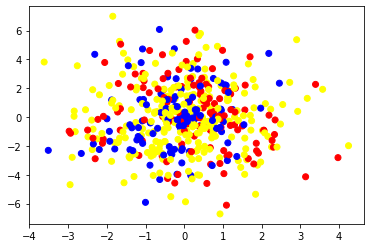

In [ ]:
import seaborn as sb
from sklearn.decomposition import PCA
avergedTrain.drop(257,inplace=True)
pca = PCA(n_components=2)

pca.fit(avergedTrain[[x  for x in avergedTrain.columns if "absorb" in x][0:150]])

d2 = pca.transform(avergedTrain[[x  for x in avergedTrain.columns if "absorb" in x][0:150]]) 
colorsEncoder =LabelEncoder()

def colorsFunc(x):
  if x == "ok":
    return "yellow"
  elif x == "low" :
    return "red"
  else :
    return "blue"

colors = [colorsFunc(i) for i in avergedTrain["hdl_cholesterol_human"] ]


# sb.regplot(x = d2[:,2], y=d2[:,1],colors , truncate=False, x_jitter=0.6, scatter_kws={'alpha':1/2});
plt.scatter(d2[:,1],d2[:,0],c=colors)

In [ ]:
trim = 10
nAvg = 10

avergedAvergedTrain  = avergedTrain[['std', 'humidity', 'temperature']]
absorbs  = [x for x in avergedTrain.columns if "absorb" in x]

for i in range(trim,len(absorbs)-trim,nAvg):
  acc = avergedTrain[absorbs[i]]
  for it in range(i+1,min(i+nAvg,len(absorbs)-trim)):
    acc += avergedTrain[absorbs[it]]
  acc = acc/ nAvg
  avergedAvergedTrain["absorb"+str(i)+"_"+str(it)] = acc

avergedAvergedTrain['cholesterol_ldl_human'] = avergedTrain["cholesterol_ldl_human"]
avergedAvergedTrain['hdl_cholesterol_human'] = avergedTrain["hdl_cholesterol_human"]
avergedAvergedTrain['hemoglobin(hgb)_human'] = avergedTrain["hemoglobin(hgb)_human"]

In [ ]:
avergedAvergedTrain

,std,humidity,temperature,absorb10_19,absorb20_29,absorb30_39,absorb40_49,absorb50_59,absorb60_69,absorb70_79,absorb80_89,absorb90_99,absorb100_109,absorb110_119,absorb120_129,absorb130_139,absorb140_149,absorb150_159,cholesterol_ldl_human,hdl_cholesterol_human,hemoglobin(hgb)_human
0,0.0073,37.773000,42.332500,0.600682,0.575539,0.571880,0.675139,0.815675,0.791252,0.798442,0.964915,1.352891,1.878952,1.914808,1.818302,1.660514,1.522860,1.430014,ok,low,ok
1,0.0043,43.316667,39.385167,0.606873,0.584431,0.577561,0.666704,0.797119,0.777231,0.778921,0.921505,1.244069,1.689107,1.722839,1.636694,1.501215,1.385650,1.310229,high,low,ok
2,0.0046,46.535167,42.455500,0.603009,0.577087,0.572696,0.667828,0.796825,0.771918,0.774911,0.931146,1.302631,1.836365,1.862614,1.730011,1.550315,1.407831,1.317406,high,low,ok
3,0.0098,37.369333,45.173333,0.596614,0.576363,0.572277,0.662022,0.781231,0.763173,0.774444,0.913991,1.212703,1.580467,1.606528,1.551905,1.450127,1.357681,1.292018,high,low,ok
4,0.0096,38.557500,45.523667,0.564453,0.542811,0.535817,0.617422,0.733062,0.713223,0.719181,0.856384,1.173798,1.597688,1.625728,1.551502,1.418558,1.301930,1.223761,ok,low,ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.0045,47.501667,39.787667,0.575970,0.549392,0.536265,0.619830,0.731718,0.710941,0.720892,0.859559,1.152312,1.467168,1.482798,1.435041,1.346251,1.261709,1.204457,ok,ok,low
482,0.0231,44.264833,42.103333,0.619007,0.593470,0.584063,0.674926,0.793643,0.774295,0.787749,0.939869,1.288398,1.756838,1.781859,1.685214,1.537870,1.418113,1.340376,high,ok,ok
483,0.0055,39.558000,39.873833,0.608709,0.583768,0.576285,0.671139,0.791947,0.774350,0.787864,0.937779,1.259488,1.658896,1.684365,1.607973,1.486153,1.381174,1.311947,high,high,ok
484,0.0138,42.647333,40.309500,0.640501,0.614141,0.603315,0.687532,0.796723,0.778413,0.792853,0.938985,1.264195,1.677715,1.700905,1.619984,1.490953,1.381096,1.306769,ok,high,ok


In [ ]:
"""
to use information from all the data and making sure the model won't overfit 
I used kfold splits on all available data and on predicting real live data I average predictions on the 5 models

"""
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE



class KfoldClassifierModel:
  def __init__(self,models,wantedColumns,meanAcc, meanF1):
    self.meanAcc = meanAcc
    self.meanF1 = meanF1
    self.models= models
    self.wantedColumns = wantedColumns
  def predict(self,xData):
    preds = [model.predict(xData[self.wantedColumns]).tolist() for model in self.models]
    preds = np.array(preds).transpose().squeeze(0)
    # print(preds.squeeze(0))
    preds = [ pd.Series(preds[i].reshape(-1)).mode().values[0] for i in range(len(preds))]
    # print(preds.shape)
    return preds



def makekFoldClfModel(data,xdataColumns,targetColumns):
  kf = StratifiedKFold(n_splits=5)  
  models = []
  accs = []
  f1s = []

  for train_index, test_index in kf.split(data,data[targetColumns[0]]):
    # print("TRAIN:", train_index, "TEST:", test_index)
    xtrain, xtest = data[xdataColumns].iloc[train_index], data[xdataColumns].iloc[test_index]
    ytrain, ytest = data.iloc[train_index][targetColumns[0]], data.iloc[test_index][targetColumns[0]]
    # xtrain,ytrain = over.fit_resample(xtrain,ytrain) 
    eval_pool = Pool(xtest,ytest)
    clf = CatBoostClassifier(iterations=90,verbose=700,learning_rate=0.0003,max_depth=5 ,l2_leaf_reg=0.8,rsm=0.7,eval_metric="Accuracy") # ldl
    # clf = CatBoostClassifier(iterations=120,verbose=300,learning_rate=0.003,max_depth=8 ,l2_leaf_reg=0.2,rsm=0.5,eval_metric="Accuracy")

    # reg1.fit(xtrain,ytrain,eval_set=eval_pool)
    clf.fit(xtrain,ytrain,eval_set=eval_pool)
    accs.append(accuracy_score(ytest,clf.predict(xtest)))
    f1s.append(f1_score(ytest,clf.predict(xtest) , average="macro"))
    # print(ytest.value_counts()/len(ytest))
    # print(pd.Series(clf.predict(xtest).reshape(-1)).value_counts()/len(xtest))
    models.append(clf)
  kFoldModel = KfoldClassifierModel(models,xdataColumns,np.mean(accs),np.mean(f1s))
  print(">>>>>>>>>>>>>>",np.mean(accs) , ">>>>>>>>>>>>>>>>>>>>>>>>>",np.mean(f1s))
  return kFoldModel

   

# clfOverall = makekFoldClfModel(avergedTrain,avergedTrain.columns[30:120 ].tolist() + ['std', 'humidity', 'temperature'],["cholesterol_ldl_human"])
# clfOverall = makekFoldClfModel(avergedTrain,avergedTrain.columns[70:170 ].tolist() + ['std', 'humidity', 'temperature'],["hemoglobin(hgb)_human"])
# clfOverall = makekFoldClfModel(avergedTrain,avergedTrain.columns[40:120 ].tolist() + ['std', 'humidity', 'temperature'],["hdl_cholesterol_human"])
# clfOverall = makekFoldClfModel(avergedAvergedTrain,avergedAvergedTrain.columns[:-3],["cholesterol_ldl_human"])
# clfOverall = makekFoldClfModel(avergedAvergedTrain,avergedAvergedTrain.columns[:-3],["hdl_cholesterol_human"])
# clfOverall = makekFoldClfModel(avergedAvergedTrain,avergedAvergedTrain.columns[:-3],["hemoglobin(hgb)_human"])
# clfOverall = makekFoldClfModel(avergedTrain,avergedTrain.columns[70:160 ].tolist() + ['std', 'humidity', 'temperature'],["hemoglobin(hgb)_human"])
# clfOverall = makekFoldClfModel(avergedTrain,avergedTrain.columns[50:130 ].tolist() + ['std', 'humidity', 'temperature'],["hdl_cholesterol_human"])


In [ ]:
def myLabelEncoder(x):
  if x=="low": return 0
  elif x == "ok" : return 1
  else:  return 2
def myLabelDecoder (x):
  if x== 0: return "low"
  elif x== 1: return "ok"
  else: return "high"

models = { }

accs = []
f1s = []
for i in avergedAvergedTrain.columns[-3:]:
  
  # xtrain, xvalid, ytrain,yvalid = train_test_split(train[train.columns[1:-3]],train[i],test_size=0.97,shuffle=True)
  
  # ytrain = ytrain.apply(myLabelEncoder)
  # yvalid = yvalid.apply(myLabelEncoder)
  data = avergedAvergedTrain.copy()
  data[i]  = data[i].apply(lambda x: myLabelEncoder(x))
  clfKfoldModel = makekFoldClfModel(data,avergedAvergedTrain.columns[:-3],[i])
  # clfKfoldModel.fit(xtrain[xtrain.columns[:10]],ytrain)
  models[i] = clfKfoldModel
  accs.append(models[i].meanAcc)
  f1s.append(models[i].meanF1)






0:	learn: 0.5850515	test: 0.5204082	best: 0.5204082 (0)	total: 4.49ms	remaining: 400ms
89:	learn: 0.5979381	test: 0.5408163	best: 0.6020408 (3)	total: 392ms	remaining: 0us

bestTest = 0.6020408163
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 0.5578406	test: 0.5360825	best: 0.5360825 (0)	total: 4.65ms	remaining: 414ms
89:	learn: 0.5964010	test: 0.5257732	best: 0.5979381 (1)	total: 390ms	remaining: 0us

bestTest = 0.5979381443
bestIteration = 1

Shrink model to first 2 iterations.
0:	learn: 0.6066838	test: 0.4226804	best: 0.4226804 (0)	total: 4.58ms	remaining: 408ms
89:	learn: 0.5861183	test: 0.5670103	best: 0.5773196 (57)	total: 391ms	remaining: 0us

bestTest = 0.5773195876
bestIteration = 57

Shrink model to first 58 iterations.
0:	learn: 0.5526992	test: 0.4845361	best: 0.4845361 (0)	total: 4.51ms	remaining: 402ms
89:	learn: 0.5938303	test: 0.5463918	best: 0.5567010 (18)	total: 388ms	remaining: 0us

bestTest = 0.5567010309
bestIteration = 18

Shrink model to first 1

In [ ]:
np.mean(accs),np.mean(f1s)

(0.6467353951890034, 0.30057312636626193)

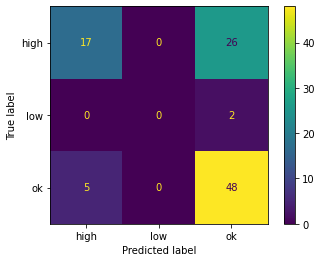

In [ ]:
from catboost.utils import get_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(models["cholesterol_ldl_human"].models[0], xvalid, yvalid["cholesterol_ldl_human"] ) 

plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score
from sklearn.naive_bayes import GaussianNB

def euclideanDistance(v1,v2):
  return  np.square(v1 - v2).sum()

class KNNClassifier:
  def __init__(self,k=3):
    self.k = k
    
  def fit(self, x:np.array,y:np.array):
    self.x = x
    self.y = y
  
  def predict(self,xtest):
    preds = []
    for i in range(len(xtest)):
      distances = []
      for xIndex in range(len(self.x)):
          distances.append([xIndex,euclideanDistance(self.x[xIndex], xtest[i])])
      distances.sort(key=lambda pair : pair[1] )
      distances= np.array(distances)
      # print(distances[-self.k:,0])
      preds.append(pd.Series(self.y[distances[:self.k,0].astype(int)]).mode().values[0])
    return preds

xtrain, xvalid, ytrain,yvalid = train_test_split(avergedAvergedTrain[avergedAvergedTrain.columns[:-3]],avergedAvergedTrain[avergedAvergedTrain.columns[-3:]],test_size=0.2,shuffle=True)

scaler = MinMaxScaler()
scaler.fit(xtrain)
xtrainScaled = scaler.transform(xtrain)
xvalidScaled = scaler.transform(xvalid)

for i in avergedAvergedTrain.columns[-3:]:
  
    knn = KNNClassifier(k=3)
    knn.fit(xtrainScaled,ytrain[i].to_numpy())
    nb = GaussianNB()
    nb.fit(xtrainScaled,ytrain[i].to_numpy())
    print("KNN "+ i+" ->>>>>>>>>>>>>",accuracy_score(yvalid[i],knn.predict(xvalidScaled)))
    print("NB "+i+ "->>>>>>>",accuracy_score(yvalid[i],nb.predict(xvalidScaled)))



KNN cholesterol_ldl_human ->>>>>>>>>>>>> 0.4897959183673469
NB cholesterol_ldl_human->>>>>>> 0.42857142857142855
KNN hdl_cholesterol_human ->>>>>>>>>>>>> 0.2653061224489796
NB hdl_cholesterol_human->>>>>>> 0.29591836734693877
KNN hemoglobin(hgb)_human ->>>>>>>>>>>>> 0.7857142857142857
NB hemoglobin(hgb)_human->>>>>>> 0.6428571428571429


## Saving the predictions

In [ ]:
test = pd.read_csv(testcsv)
test.head()

avergedTest  = test[['std', 'humidity', 'temperature']]
absorbs  = [x for x in test.columns if "absorb" in x]

for i in range(trim,len(absorbs)-trim,nAvg):
  acc = test[absorbs[i]]
  for it in range(i+1,min(i+nAvg,len(absorbs)-trim)):
    acc += test[absorbs[it]]
  acc = acc/ nAvg
  avergedTest["absorb"+str(i)+"_"+str(it)] = acc



In [ ]:
test.donation_id.value_counts()

ID_7755    60
ID_6317    60
ID_2524    60
ID_6319    60
ID_2989    60
           ..
ID_5730    60
ID_4153    60
ID_2436    60
ID_6321    60
ID_2557    60
Name: donation_id, Length: 61, dtype: int64

In [ ]:
# save it ids before dropping them
idx = test.donation_id.values
# test.drop(["donation_id"], axis=1, inplace=True)
testdata = avergedTest

In [ ]:
print(testdata.shape) # 61 Individuals

(3660, 18)


### submissino process



Key:
low  = 0,
ok   = 1,
high = 2

In [ ]:
def mymodel(features):
    predictions = np.zeros((len(features),3))
    for i,columnIdx in zip(avergedTrain.columns[-3:],range(3)):
      predictions[:,columnIdx]  = models[i].predict(features)

    return predictions

In [ ]:
predictions = mymodel(avergedTest)
# Save the results to csv
ss = pd.DataFrame()
ss["Reading_ID"] = idx # don't messed up the ids. save them before.
ss["hdl_cholesterol_human"] = predictions[:,0]
ss["hemoglobin(hgb)_human"] = predictions[:,1]
ss["cholesterol_ldl_human"] = predictions[:,2]


##### - We need to transform our predictions from 0, 1, 2 to low, ok, high respectively 

In [ ]:
def transform(value):
    if value == 0.0:
        return 'low'
    elif value == 1.0:
        return 'ok'
    else:
        return 'high'
        

In [ ]:
ss["hdl_cholesterol_human"] = ss["hdl_cholesterol_human"].apply(lambda x: transform(x))
ss["hemoglobin(hgb)_human"] = ss["hemoglobin(hgb)_human"].apply(lambda x: transform(x))
ss["cholesterol_ldl_human"] = ss["cholesterol_ldl_human"].apply(lambda x: transform(x))

In [ ]:
ss["hdl_cholesterol_human"].value_counts()

ok      3485
high     175
Name: hdl_cholesterol_human, dtype: int64

#### -  Convert our submission as per the sample submission 

In [ ]:
def transform_c_hdl(row):
    return str(row["Reading_ID"]) + "_hdl_cholesterol_human" + "-" +  row["hdl_cholesterol_human"]

In [ ]:
hdl_rows = pd.DataFrame(ss.apply(transform_c_hdl, axis=1))

In [ ]:
def transform_hemo(row):
    return str(row["Reading_ID"]) + "_hemoglobin(hgb)_human" +  "-" + row["hemoglobin(hgb)_human"]

In [ ]:
hemo_rows = pd.DataFrame(ss.apply(transform_hemo, axis=1))

In [ ]:
def transform_c_ldl(row):
    return str(row["Reading_ID"]) + "_cholesterol_ldl_human" +  "-" + row["cholesterol_ldl_human"]

In [ ]:
ldl_rows = pd.DataFrame(ss.apply(transform_c_ldl, axis=1))

In [ ]:
ss = pd.concat([hdl_rows, hemo_rows, ldl_rows]).reset_index(drop=True)

In [ ]:
ss["target"] = ss[0].apply(lambda x: x.split("-")[1])
ss[0] = ss[0].apply(lambda x: x.split("-")[0])

In [ ]:
ss = ss.rename(columns={0:"Reading_ID"})

In [ ]:
ss.to_csv("./subsubfinalsubmission.csv", index=False)